# RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
from copy import deepcopy

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from collections import defaultdict
from collections import deque
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16
%matplotlib inline

C:\Users\artys\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Опсиание среды

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

## Функция для отрисовки средних выигрышей

In [4]:
def draw_rewards(algorithm, crosses_rewards, zeros_rewards, print_every=1):
    
    print(f'Данные о среднем выигрыше по всем сыгранным {len(crosses_rewards)} играм для крестиков')
    print(f'Данные о среднем выигрыше по всем сыгранным {len(zeros_rewards)} играм для ноликов')

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set_xlabel('Количество игр', fontsize=14)
    ax.set_ylabel('Средний кумулятивный выигрыш', fontsize=14)

    mean_cum_rewards_crosses = np.true_divide(np.nancumsum(crosses_rewards), np.arange(1, len(crosses_rewards)+1))
    mean_cum_rewards_zeros = np.true_divide(np.nancumsum(zeros_rewards), np.arange(1, len(zeros_rewards)+1))

    ax.plot(np.arange(1, len(mean_cum_rewards_crosses)+1)[print_every::print_every], 
            mean_cum_rewards_crosses[print_every::print_every], 
            label=f'{algorithm} - крестики')
    ax.plot(np.arange(1, len(mean_cum_rewards_zeros)+1)[print_every::print_every], 
            mean_cum_rewards_zeros[print_every::print_every], 
            label=f'{algorithm} - нолики')

    ax.legend(fontsize=14)    
    
    plt.show()

# Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

## Task 1-2

In [5]:
# Стратегия, которую обучаем
def e_greedy(env, Q, epsilon = 0.01):
    state = env.getState()
    state_mask, possible_actions, player_num = state
    if state_mask not in Q.keys():
        Q[state_mask] = np.zeros(len(possible_actions))
    
    if np.random.random() > epsilon:
        return np.argmax(Q[state_mask]), possible_actions[np.argmax(Q[state_mask])]
    else:
        action_num = np.random.choice(len(possible_actions))
        return action_num, possible_actions[action_num]

In [6]:
# Стратегия с которой играем при обучении
def opponet_strategy(env, Q = None):
    if Q is None:
        possible_actions = env.getState()[1]
        action_num = np.random.choice(len(possible_actions))
    else:
        NotImplemented()
    
    return action_num, possible_actions[action_num]

In [7]:
# Один эпизод игры
def Q_learning_episode(env, crosses_flg, Q, opponents_Q=None, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    
    # Crosses goes first
    if env.curTurn != crosses_flg:
        # Opponent player turn
        num_action_opponent, action_opponent = opponet_strategy(env)
        _, _, done, _ = env.step(action_opponent)
        
    while True:
        # Learning player turn
        state = env.getState()
        state_mask, possible_actions, player_num = state
        num_action, action = e_greedy(env, Q)
        _, reward, done, _ = env.step(action)
        reward = reward * crosses_flg
        if done:
            break

        # Opponent player turn
        num_action_opponent, action_opponent = opponet_strategy(env, opponents_Q)
        state_new, reward, done, _ = env.step(action_opponent)
        reward = reward * crosses_flg
        if done:
            break

        # Updating learning Q
        state_mask_new, possible_actions_new, player_num_new = state_new
        if state_mask_new not in Q.keys():
            Q[state_mask_new] = np.zeros(len(possible_actions_new))
        Q[state_mask][num_action] += alpha * (reward + gamma * np.max(Q[state_mask_new]) - Q[state_mask][num_action])


    # Update if done
    Q[state_mask][num_action] += alpha * (reward  - Q[state_mask][num_action])
    
    return Q, reward

In [8]:
# Функция для обучения алгоритма
def Qlearning(env, 
              crosses_flg=1, 
              opponents_Q=None, 
              total_episodes=100,
              alpha=0.05, 
              epsilon=0.0, 
              gamma=0.9
             ):
    Q = {}
    rewards_list = []
    
    for i in tqdm_notebook(range(total_episodes)):
        Q, reward = Q_learning_episode(env, crosses_flg, Q, opponents_Q, alpha, epsilon, gamma)
        rewards_list.append(reward)
    
    return Q, rewards_list

### Поле 3x3

In [9]:
%%time
total_episodes=10**5
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

Q_crosses, Q_crosses_rewards = Qlearning(env, 
                                         crosses_flg=1, 
                                         opponents_Q=None, 
                                         total_episodes=total_episodes,
                                         alpha=0.01, 
                                         epsilon=0.01, 
                                         gamma=1
                                        )

Q_zeros, Q_zeros_rewards = Qlearning(env, 
                                     crosses_flg=-1, 
                                     opponents_Q=None, 
                                     total_episodes=total_episodes,
                                     alpha=0.01, 
                                     epsilon=0.01, 
                                     gamma=1
                                    )


Wall time: 1min 54s


Данные о среднем выигрыше по всем сыгранным 100000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 100000 играм для ноликов


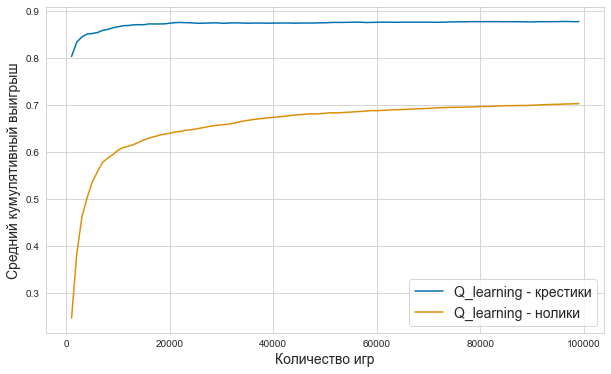

In [10]:
draw_rewards(algorithm='Q_learning', 
             crosses_rewards=Q_crosses_rewards, 
             zeros_rewards=Q_zeros_rewards,
             print_every=total_episodes//100
            )

### Поле 4x4

In [11]:
%%time
total_episodes=10**5
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)

Q_crosses, Q_crosses_rewards = Qlearning(env, 
                                         crosses_flg=1, 
                                         opponents_Q=None, 
                                         total_episodes=total_episodes,
                                         alpha=0.01, 
                                         epsilon=0.01, 
                                         gamma=1
                                        )

Q_zeros, Q_zeros_rewards = Qlearning(env, 
                                     crosses_flg=-1, 
                                     opponents_Q=None, 
                                     total_episodes=total_episodes,
                                     alpha=0.01, 
                                     epsilon=0.01, 
                                     gamma=1
                                    )


Wall time: 2min 33s


Данные о среднем выигрыше по всем сыгранным 100000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 100000 играм для ноликов


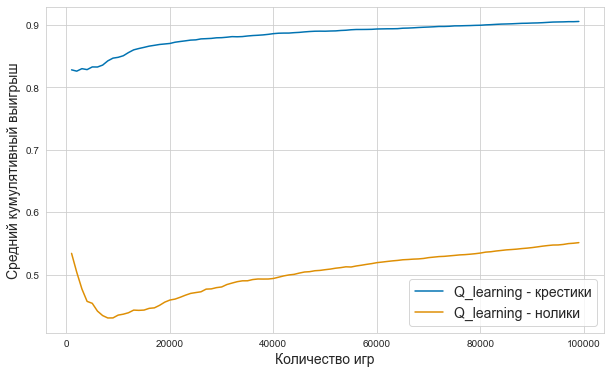

In [12]:
draw_rewards(algorithm='Q_learning', 
             crosses_rewards=Q_crosses_rewards, 
             zeros_rewards=Q_zeros_rewards,
             print_every=total_episodes//100
            )

### Поле 5x5

In [13]:
%%time
total_episodes=10**5
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)

Q_crosses, Q_crosses_rewards = Qlearning(env, 
                                         crosses_flg=1, 
                                         opponents_Q=None, 
                                         total_episodes=total_episodes,
                                         alpha=0.01, 
                                         epsilon=0.01, 
                                         gamma=1
                                        )

Q_zeros, Q_zeros_rewards = Qlearning(env, 
                                     crosses_flg=-1, 
                                     opponents_Q=None, 
                                     total_episodes=total_episodes,
                                     alpha=0.01, 
                                     epsilon=0.01, 
                                     gamma=1
                                    )


Wall time: 2min 53s


Данные о среднем выигрыше по всем сыгранным 100000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 100000 играм для ноликов


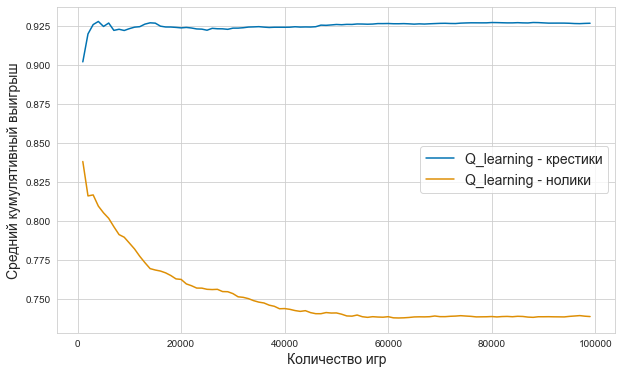

In [14]:
draw_rewards(algorithm='Q_learning', 
             crosses_rewards=Q_crosses_rewards, 
             zeros_rewards=Q_zeros_rewards,
             print_every=total_episodes//100
            )

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.

## Task 3

In [15]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [16]:
class Network(nn.Module):
    def __init__(self, rows, cols):
        super(Network, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )
        self.fc1 = nn.Linear(rows * cols * 32, 128)
        self.fc2 = nn.Linear(128, rows*cols)

    def forward(self, x): 
        out = self.layer1(x) 
        out = out.reshape(x.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

In [17]:
class TicTocDQN():
    def __init__(self, env, crosses_flg, net):
        self.env = env
        self.crosses_flg = crosses_flg
        self.model = net
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.rewards_list = []
        self.loss_list = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0

    def select_greedy_action(self, possible_moves, state_board):
        possible_moves = np.array(possible_moves)
        possible_moves = torch.tensor(possible_moves, dtype=torch.long)
        
        net_out = self.model(torch.tensor(np.array([[state_board]]), dtype=torch.float32))
        net_out_possible = net_out[0][possible_moves]
        
        action_num = net_out_possible.argmax()
        action = possible_moves[action_num]
        return action
    
    def select_random_action(self, possible_moves, state_board):
        random_action = random.choice(possible_moves)
        return random_action
        
    def select_action(self, possible_moves, state_board):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(possible_moves, state_board)
        else:
            return self.select_random_action(possible_moves, state_board)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        num_step = 0
        loss_sum = 0
        self.env.reset()

        # Crosses goes first
        if self.env.curTurn != self.crosses_flg:
            # Opponent player turn
            possible_moves = [self.env.int_from_action(i) for i in self.env.getEmptySpaces()]
            state_board = self.env.board
            action_opponent = self.select_random_action(possible_moves, state_board)
            _, _, done, _ = self.env.step(self.env.action_from_int(int(action_opponent)))

        while True:
            if render:
                self.env.render()
            
            # Learning player turn
            state = self.env.getState()
            possible_actions = [self.env.int_from_action(i) for i in state[1]]
            state_board = self.env.board
            
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(possible_actions, state_board)
                else:
                    action = self.select_action(possible_actions, state_board)
            
            _, reward, done, _ = self.env.step(self.env.action_from_int(int(action)))

            reward = reward * self.crosses_flg
            if done:
                # Adding transaction
                state_board_tensor = torch.tensor([state_board], dtype=torch.float32)
                state_board_new_tensor = torch.tensor([state_board_new], dtype=torch.float32)
            
                transition = (possible_actions, 
                          [state_board],
                          action, 
                          possible_actions_new,
                          [state_board_new_tensor],
                          reward)
                self.memory.store(transition)

                if do_learning:
                    self.learn()

                if done:
                    self.rewards_list.append(reward)
                    self.loss_list.append(loss_sum)
                    break

            # Opponent player turn
            possible_moves_opponent = [self.env.int_from_action(i) for i in self.env.getEmptySpaces()]
            state_board_opponent = self.env.board
            action_opponent = self.select_random_action(possible_moves_opponent, state_board_opponent)
            state_new, reward, done, _ = self.env.step(self.env.action_from_int(int(action_opponent)))
            possible_actions_new = [self.env.int_from_action(i) for i in state_new[1]]
            state_board_new = self.env.board
            reward = reward * self.crosses_flg

    
            # Adding transaction
            state_board_tensor = torch.tensor([state_board], dtype=torch.float32)
            state_board_new_tensor = torch.tensor([state_board_new], dtype=torch.float32)
            
            transition = (possible_actions, 
                          [state_board],
                          action, 
                          possible_actions_new,
                          [state_board_new_tensor],
                          reward)
            self.memory.store(transition)
            
            if do_learning:
                loss = self.learn()
                loss_sum += loss

            if done:
                self.rewards_list.append(reward)
                self.loss_list.append(loss_sum)
                break


    def learn(self):
        if len(self.memory) < self.batch_size:
            return np.inf

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        
        batch_possible_actions = [el[0] for el in transitions]
        batch_state_board = [el[1] for el in transitions]
        batch_action = [el[2] for el in transitions]
        batch_possible_actions_new = [el[3] for el in transitions]
        batch_state_board_new = [el[4] for el in transitions]
        batch_reward = [el[5] for el in transitions]
        
        batch_state_board = Variable(torch.tensor(np.array(batch_state_board), dtype=torch.float32))
        batch_state_board_new = Variable(torch.tensor(np.array(batch_state_board), dtype=torch.float32))
        batch_action = torch.tensor(np.array(batch_action), dtype=torch.long).reshape((-1, 1))
        batch_reward = torch.tensor(np.array(batch_reward), dtype=torch.long).reshape((-1, 1))
        
        # считаем значения функции Q
        Q = self.model(batch_state_board).gather(1, batch_action)

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_state_board_new).detach().max(1)[0].reshape((-1, 1))
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

### Поле 3х3

In [18]:
%%time
total_episodes=5000
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

# Учимся играть крестиками
dqn_crosses = TicTocDQN(env = env, crosses_flg = 1, net = Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_crosses.run_episode(e, do_learning=True)
    
# Учимся играть ноликами
dqn_zeros = TicTocDQN(env = env, crosses_flg = -1, net = Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_zeros.run_episode(e, do_learning=True)



Wall time: 10min 53s


Данные о среднем выигрыше по всем сыгранным 5000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 5000 играм для ноликов


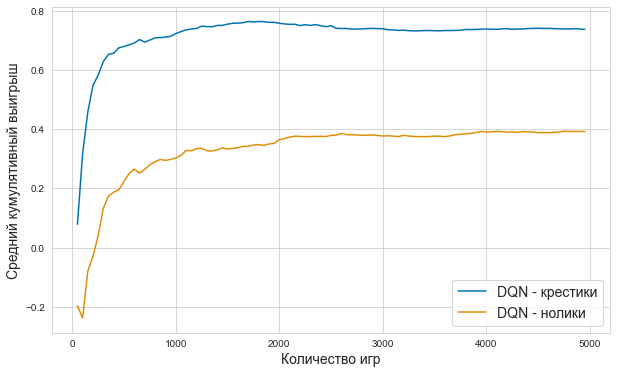

In [19]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=dqn_crosses.rewards_list, 
             zeros_rewards=dqn_zeros.rewards_list,
             print_every=total_episodes//100
            )

### Поле 4х4

In [20]:
%%time
total_episodes=5000
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)

# Учимся играть крестиками
dqn_crosses = TicTocDQN(env = env, crosses_flg = 1, net = Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_crosses.run_episode(e, do_learning=True)
    
# Учимся играть ноликами
dqn_zeros = TicTocDQN(env = env, crosses_flg = -1, net = Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_zeros.run_episode(e, do_learning=True)


Wall time: 15min 22s


Данные о среднем выигрыше по всем сыгранным 5000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 5000 играм для ноликов


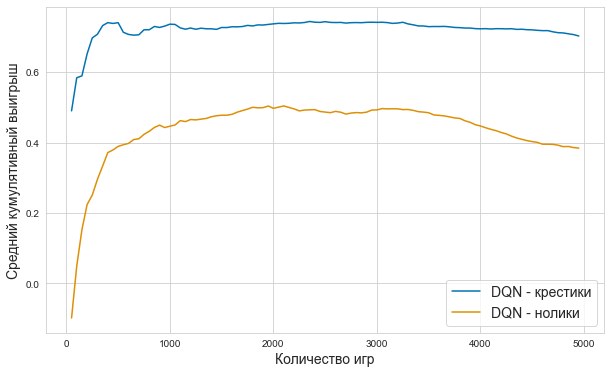

In [21]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=dqn_crosses.rewards_list, 
             zeros_rewards=dqn_zeros.rewards_list,
             print_every=total_episodes//100
            )

### Поле 5х5

In [22]:
%%time
total_episodes=5000
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)

# Учимся играть крестиками
dqn_crosses = TicTocDQN(env = env, crosses_flg = 1, net = Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_crosses.run_episode(e, do_learning=True)
    
# Учимся играть ноликами
dqn_zeros = TicTocDQN(env = env, crosses_flg = -1, net = Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_zeros.run_episode(e, do_learning=True)


Wall time: 29min 3s


Данные о среднем выигрыше по всем сыгранным 5000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 5000 играм для ноликов


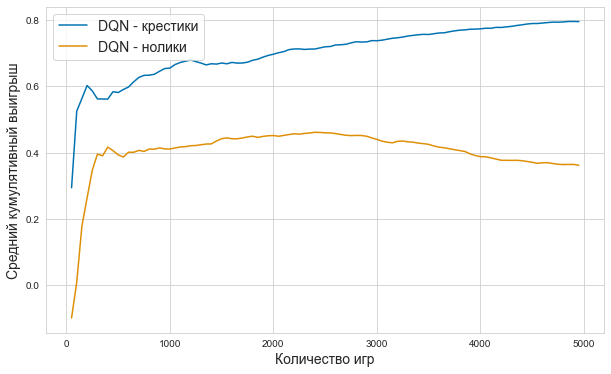

In [23]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=dqn_crosses.rewards_list, 
             zeros_rewards=dqn_zeros.rewards_list,
             print_every=total_episodes//100
            )

## Task 4

In [24]:
class DuelingDQN_Network(nn.Module):
    def __init__(self, rows, cols):
        super(DuelingDQN_Network, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )

        self.value_stream = nn.Sequential(
            nn.Linear(rows * cols * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(rows * cols * 32, 128),
            nn.ReLU(),
            nn.Linear(128, rows * cols)
        )
        
    def forward(self, state):
        
        features = self.conv(state)
        features = features.reshape(features.size(0), -1)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean(1).reshape((-1,1)))
        
        return qvals

### Поле 3х3

In [25]:
%%time
total_episodes=1000
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

# Учимся играть крестиками
dqn_crosses = TicTocDQN(env = env, crosses_flg = 1, net = DuelingDQN_Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_crosses.run_episode(e, do_learning=True)
    
# Учимся играть ноликами
dqn_zeros = TicTocDQN(env = env, crosses_flg = -1, net = DuelingDQN_Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_zeros.run_episode(e, do_learning=True)



Wall time: 4min 40s


Данные о среднем выигрыше по всем сыгранным 1000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 1000 играм для ноликов


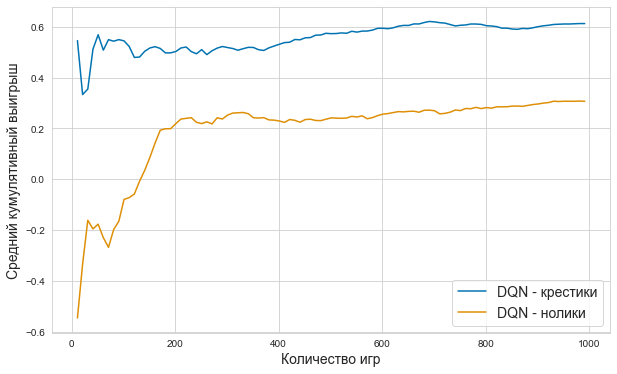

In [26]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=dqn_crosses.rewards_list, 
             zeros_rewards=dqn_zeros.rewards_list,
             print_every=total_episodes//100
            )

### Поле 4х4

In [27]:
%%time
total_episodes=1000
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)

# Учимся играть крестиками
dqn_crosses = TicTocDQN(env = env, crosses_flg = 1, net = DuelingDQN_Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_crosses.run_episode(e, do_learning=True)
    
# Учимся играть ноликами
dqn_zeros = TicTocDQN(env = env, crosses_flg = -1, net = DuelingDQN_Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_zeros.run_episode(e, do_learning=True)


Wall time: 6min 13s


Данные о среднем выигрыше по всем сыгранным 1000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 1000 играм для ноликов


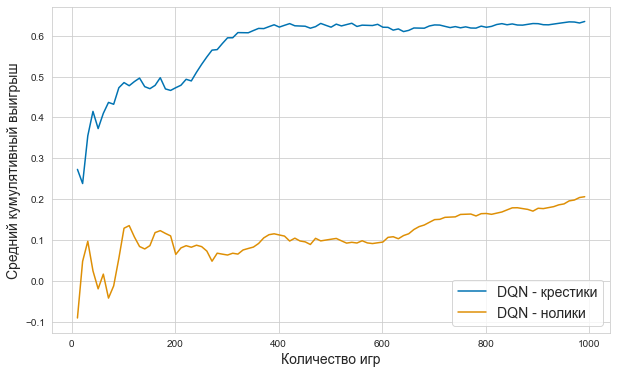

In [28]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=dqn_crosses.rewards_list, 
             zeros_rewards=dqn_zeros.rewards_list,
             print_every=total_episodes//100
            )

### Поле 5х5

In [29]:
%%time
total_episodes=1000
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)

# Учимся играть крестиками
dqn_crosses = TicTocDQN(env = env, crosses_flg = 1, net = DuelingDQN_Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_crosses.run_episode(e, do_learning=True)
    
# Учимся играть ноликами
dqn_zeros = TicTocDQN(env = env, crosses_flg = -1, net = DuelingDQN_Network(env.n_rows, env.n_cols))
for e in tqdm_notebook(range(total_episodes)):
    dqn_zeros.run_episode(e, do_learning=True)


Wall time: 7min 18s


Данные о среднем выигрыше по всем сыгранным 1000 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 1000 играм для ноликов


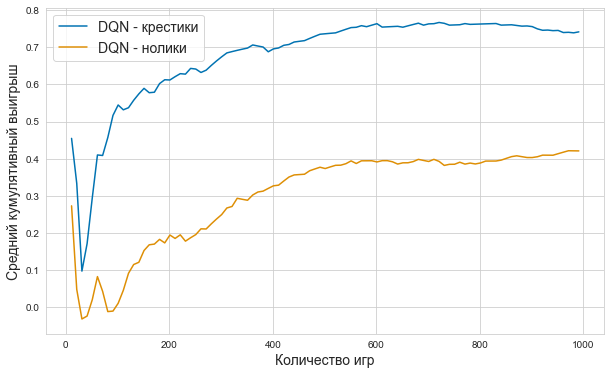

In [30]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=dqn_crosses.rewards_list, 
             zeros_rewards=dqn_zeros.rewards_list,
             print_every=total_episodes//100
            )

# Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

## Task 5

In [31]:
# Функция rollout для определенного состояния
# Для каждого действия определяем среднюю награду
def rollout(env, strategy, nrolls, crosses_flg):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    rewards = {el: [] for el in possible_actions}
    for i in range(nrolls):
        for act in possible_actions:
            cur_env = deepcopy(env)
            _, reward, done, _ = cur_env.step(cur_env.action_from_int(act))
            if done:
                rewards[act].append(reward * crosses_flg)
                continue
                
            while True:
                #opponents turn
                p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
                opponents_action = np.random.choice(p_actions)
                _, reward, done, _ = cur_env.step(cur_env.action_from_int(opponents_action))
                if done:
                    rewards[act].append(reward * crosses_flg)
                    break
                
                #our turn
                p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
                our_action = strategy(cur_env)
                
                _, reward, done, _ = cur_env.step(cur_env.action_from_int(our_action))
                if done:
                    rewards[act].append(reward * crosses_flg)
                    break
                    
    actions = {el: np.mean(rewards[el]) for el in possible_actions}
    max_reward = -10
    best_act = 0
    for act in actions.keys():
        if actions[act] > max_reward:
            best_act = act
            max_reward = actions[act]
    return best_act, actions

In [32]:
# Моделирование игры со стратегией, определенной rollout
def rollout_game(env, strategy, nrolls = 100, crosses_flg = 1):
    if crosses_flg != env.curTurn:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
    
    while True:
        #our turn
        p_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        our_action, _ = rollout(env, strategy, nrolls, crosses_flg)
                
        _, reward, done, _ = env.step(env.action_from_int(our_action))
        
        if done:
            return reward * crosses_flg
        
        #opponents turn
        p_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(p_actions)
        
        _, reward, done, _ = env.step(env.action_from_int(opponents_action))
        
        if done:
            return reward * crosses_flg

In [33]:
# Стратегия которая используется для вычисления среднего выигрыша с помощью rollout
def random_str(env):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    return possible_actions[np.random.choice(len(possible_actions))]

### Поле 3х3

In [34]:
%%time
total_episodes=100
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

# Учимся играть крестиками
rewards_crosses = []
for i in tqdm_notebook(range(total_episodes)):
    env.reset()
    rewards_crosses.append(rollout_game(env, random_str, nrolls = 100, crosses_flg = 1))
    
# Учимся играть ноликами
rewards_zeros = []
for i in tqdm_notebook(range(total_episodes)):
    env.reset()
    rewards_zeros.append(rollout_game(env, random_str, nrolls = 100, crosses_flg = -1))



Wall time: 6min 35s


Данные о среднем выигрыше по всем сыгранным 100 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 100 играм для ноликов


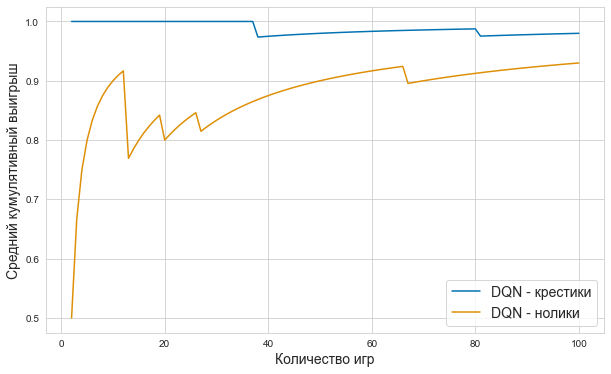

Средний выигрыш крестиков: 0.98
Средний выигрыш ноликов: 0.93


In [35]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=rewards_crosses, 
             zeros_rewards=rewards_zeros,
             print_every=total_episodes//100
            )
print('Средний выигрыш крестиков:', np.mean(rewards_crosses))
print('Средний выигрыш ноликов:', np.mean(rewards_zeros))

### Поле 4х4

In [36]:
%%time
total_episodes=100
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)

# Учимся играть крестиками
rewards_crosses = []
for i in tqdm_notebook(range(total_episodes)):
    env.reset()
    rewards_crosses.append(rollout_game(env, random_str, nrolls = 100, crosses_flg = 1))
    
# Учимся играть ноликами
rewards_zeros = []
for i in tqdm_notebook(range(total_episodes)):
    env.reset()
    rewards_zeros.append(rollout_game(env, random_str, nrolls = 100, crosses_flg = -1))



Wall time: 26min 10s


Данные о среднем выигрыше по всем сыгранным 100 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 100 играм для ноликов


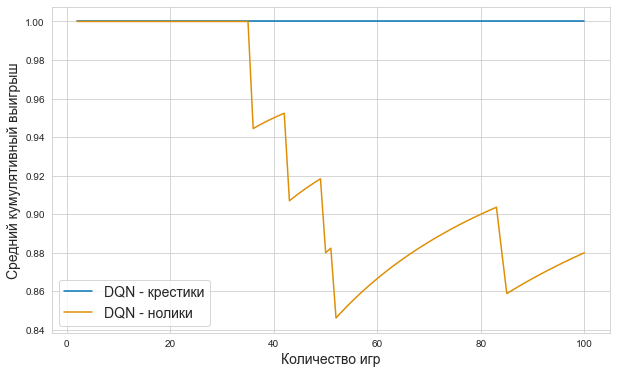

Средний выигрыш крестиков: 1.0
Средний выигрыш ноликов: 0.88


In [37]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=rewards_crosses, 
             zeros_rewards=rewards_zeros,
             print_every=total_episodes//100
            )
print('Средний выигрыш крестиков:', np.mean(rewards_crosses))
print('Средний выигрыш ноликов:', np.mean(rewards_zeros))

### Поле 5х5

In [38]:
%%time
total_episodes=100
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)

# Учимся играть крестиками
rewards_crosses = []
for i in tqdm_notebook(range(total_episodes)):
    env.reset()
    rewards_crosses.append(rollout_game(env, random_str, nrolls = 100, crosses_flg = 1))
    
# Учимся играть ноликами
rewards_zeros = []
for i in tqdm_notebook(range(total_episodes)):
    env.reset()
    rewards_zeros.append(rollout_game(env, random_str, nrolls = 100, crosses_flg = -1))



Wall time: 1h 2min 50s


Данные о среднем выигрыше по всем сыгранным 100 играм для крестиков
Данные о среднем выигрыше по всем сыгранным 100 играм для ноликов


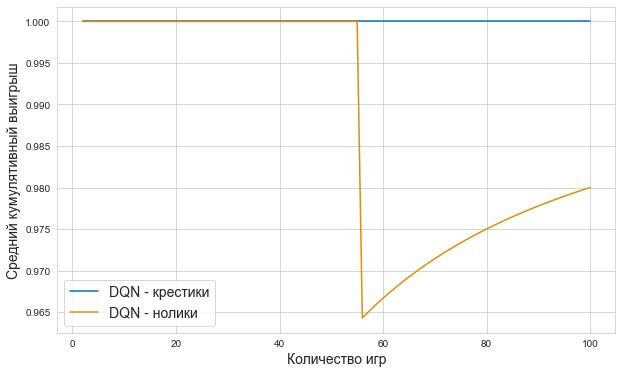

Средний выигрыш крестиков: 1.0
Средний выигрыш ноликов: 0.98


In [39]:
draw_rewards(algorithm='DQN', 
             crosses_rewards=rewards_crosses, 
             zeros_rewards=rewards_zeros,
             print_every=total_episodes//100
            )
print('Средний выигрыш крестиков:', np.mean(rewards_crosses))
print('Средний выигрыш ноликов:', np.mean(rewards_zeros))

## Task 6

In [40]:
def replace(s, position, character):
    return s[:position] + character + s[position+1:]

In [41]:
C = 0.8

class Node():
    def __init__(self):
        self.parent = None
        self.children = {}
        self.visits = 0
        self.value = 0
        self.state = None
        self.index = 0
        self.storage = None
    
    def ucb(self):
        if self.visits == 0:
            return float('inf')
        return self.value / self.visits + C * math.sqrt(math.log(self.storage[self.parent].visits) / self.visits)
    
    def create_children(self):
        if self.is_leaf():
            np_state = np.array(list(map(int, self.state)))
            available_actions = np.where(np_state == 1)[0]
            if (len(self.state) - len(available_actions)) % 2 == 0:
                curTurn = 1
            else:
                curTurn = -1
            for action in available_actions:
                child = Node()
                child.parent = self.index
                child.state = replace(self.state, action, str(curTurn + 1))
                child.index = len(self.storage)
                child.storage = self.storage
                self.children[action] = child.index
                self.storage.append(child)
    
    def is_leaf(self):
        return len(self.children) == 0
    
    def select_child(self, how="best"):
        eps = 0.7
        if how == "best":
            fun = max
            characteristic = lambda x: self.storage[x[1]].ucb()
        elif how == "worse":
            fun = min
            characteristic = lambda x: self.storage[x[1]].ucb()
        elif how == "random":
            return random.choice(list(self.children.items()))
        else:
            fun = None
            characteristic = None
        if not self.is_leaf():
            return max(self.children.items(), key=characteristic)

In [42]:
def rollout(env, strategy, nrolls, crosses_flg):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    cur_env= deepcopy(env)
    done = env.gameOver
    if done:
        return 0 
    
    while True:
        #our turn
        p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
        our_action = strategy(cur_env)
                
        _, reward, done, _ = cur_env.step(cur_env.action_from_int(our_action))
        if done:
            return reward * crosses_flg
        
        #opponents turn
        p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
        opponents_action = np.random.choice(p_actions)
        _, reward, done, _ = cur_env.step(cur_env.action_from_int(opponents_action))
        if done:
            return reward * crosses_flg

In [43]:
class Mcts():
    def __init__(self, env, crosses_flg):
        self.env = env
        self.env.reset()
        self.crosses_flg = crosses_flg
        self.nodes = []

        root = Node()
        root.state = self.env.getState()[0]
        root.index = 0
        root.storage = self.nodes
        self.nodes.append(root)
        
        self.current_node = 0
        
    def next_step(self):
        action, self.current_node = self.nodes[self.current_node].select_child()
        self.env.step(self.env.action_from_int(action))
    
    def selection(self):
        while not self.nodes[self.current_node].is_leaf():
            self.next_step()
    
    def expansion(self):
        if not self.env.gameOver:
            if self.nodes[self.current_node].visits > 0:
                self.nodes[self.current_node].create_children()
                self.next_step()
    
    def simulation(self):
        return rollout(self.env, random_str, 1, self.crosses_flg)
    
    def backpropagation(self, r):
        while self.nodes[self.current_node].parent is not None:
            self.nodes[self.current_node].visits += 1
            self.nodes[self.current_node].value += r
            self.current_node = self.nodes[self.current_node].parent
        self.nodes[self.current_node].visits += 1
        self.nodes[self.current_node].value += r
    
    def learn(self, n_episodes=10000):
        for _ in tqdm_notebook(range(n_episodes)):
            assert self.current_node == 0
            self.env.reset()
            self.selection()
            self.expansion()
            r = self.simulation()
            self.backpropagation(r)

In [44]:
def run(model, crosses_flg, n_episodes = 12):
    cum_rewards = 0
    count_games = 0
    for _ in range(n_episodes):
        model.env.reset()
        model.current_node = 0
        if crosses_flg == 1:
            hows = [None, "best", "random"]
        elif crosses_flg == -1:
            hows = [None, "random", "worse"]
        else:
            hows = None
        while not model.nodes[model.current_node].is_leaf():
            action, model.current_node = model.nodes[model.current_node].select_child(hows[model.env.curTurn])
            _, reward, done, _ = model.env.step(model.env.action_from_int(action))
        if done:
            cum_rewards += reward * crosses_flg
            count_games += 1
    mean_reward = cum_rewards / count_games
    print(f"Mean reward vs random policy equal {mean_reward} after {count_games} games.")
#     return mean_reward

### Поле 3х3

In [45]:
%%time
total_episodes=100000
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

# Учимся играть крестиками
mcts = Mcts(env, crosses_flg=1)
mcts.learn(n_episodes=total_episodes)
run(mcts, mcts.crosses_flg, 10000)

# Учимся играть ноликами
mcts = Mcts(env, crosses_flg=-1)
mcts.learn(n_episodes=total_episodes)
run(mcts, mcts.crosses_flg, 10000)


Mean reward vs random policy equal 0.7653569452130603 after 1807 games.



Mean reward vs random policy equal 0.44187725631768954 after 1385 games.
Wall time: 1min 56s


### Поле 4х4

In [48]:
%%time
total_episodes=100000
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)

# Учимся играть крестиками
mcts = Mcts(env, crosses_flg=1)
mcts.learn(n_episodes=total_episodes)
run(mcts, mcts.crosses_flg, 10000)

# Учимся играть ноликами
mcts = Mcts(env, crosses_flg=-1)
mcts.learn(n_episodes=total_episodes)
run(mcts, mcts.crosses_flg, 10000)



Mean reward vs random policy equal 0.9029126213592233 after 824 games.



Mean reward vs random policy equal 0.02857142857142857 after 70 games.
Wall time: 9min 28s


### Поле 5х5

In [49]:
%%time
total_episodes=100000
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)

# Учимся играть крестиками
mcts = Mcts(env, crosses_flg=1)
mcts.learn(n_episodes=total_episodes)
run(mcts, mcts.crosses_flg, 10000)

# Учимся играть ноликами
mcts = Mcts(env, crosses_flg=-1)
mcts.learn(n_episodes=total_episodes)
run(mcts, mcts.crosses_flg, 10000)



Mean reward vs random policy equal 1.0 after 62 games.



Mean reward vs random policy equal 0.1111111111111111 after 9 games.
Wall time: 14min 32s
